# Disputed Classification

*February 9*

In [2]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk

In [3]:
input_dir = "/Users/rosamondthalken/Documents/Projects/SupremeCourt/SupremeCourtPython/DataX/scdb_court_merged.csv"
sc_opinion_df = pd.read_csv(input_dir)

/Users/rosamondthalken/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (60) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
metadata_df = sc_opinion_df[["Unnamed: 0", "usCite", "caseName", "precedentAlteration", "issue", "author_name", "category", "per_curiam", "year_filed", "scdb_decision_direction", "scdb_votes_majority", "scdb_votes_minority", "text"]].copy()

## Set up functions

In [58]:
def get_accuracy_scores(data_frame, X_value_column, y_value_column):

    vectorizer = TfidfVectorizer(
        encoding='utf-8',
        min_df=.1,
        binary=False,
        stop_words='english',
        norm='l2',
        use_idf=True 
    )

    X = vectorizer.fit_transform(data_frame[X_value_column])
    y = data_frame[y_value_column].astype(int)
    lr = LogisticRegression()

    scores = cross_validate(lr, X, y, cv=10, scoring=['accuracy', 'f1', 'f1_macro', 'f1_micro'])
    test_f1 = np.mean(scores.get("test_f1"))
    test_accuracy = np.mean(scores.get("test_accuracy"))
    lr.fit(X, y)

    return scores, test_f1, test_accuracy, lr, vectorizer, X, y

In [40]:
# Coefficient
def get_coef_df(trained_model, trained_vectorizer):
    coef_dict = {}

    for coef, feat in zip(trained_model.coef_[0], trained_vectorizer.get_feature_names()):
        coef_dict[feat] = coef

    dict_df = pd.DataFrame.from_dict(coef_dict, orient='index')
    dict_df['feature'] = dict_df.index
    dict_df = dict_df.sort_values(by=[0], ascending=False)#.head(20)

    return coef_dict, dict_df

In [17]:
# Plot Coefficient
def plot_top_coef(coef_df, more_like_1 = True, num_to_plot = 20, x = 0, y = "feature"):
    if more_like_1:
        top_coef = dict_df.head(num_to_plot)
        fig, ax = plt.subplots(figsize=(12,8))
        plt.title('Top ' + str(num_to_plot)+' words suggesting 1')
        ax = sns.barplot(x=0, y="feature", data=top_coef)   
    else:
        top_coef = dict_df.tail(num_to_plot)
        fig, ax = plt.subplots(figsize=(12,8))
        plt.title('Top ' + str(num_to_plot)+' words suggesting 0')
        ax = sns.barplot(x=0, y="feature", data=top_coef)
    plt.show()

In [8]:
# Confusion Matrix
def plot_confusion_matrix(X, y, trained_model):
    y_best = trained_model.predict(X)
    confusion_m = metrics.confusion_matrix(y, y_best)

    sns.set(font_scale=2)
    fig, ax = plt.subplots(figsize=(10,6))
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_percentages = ["{0:.2%}".format(value) for value in
                        confusion_m.flatten()/np.sum(confusion_m)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
            zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(ax = ax, data = confusion_m, annot=labels, fmt="", cmap="Blues")
    plt.show()

## Create metadata for classification

In [53]:
# SPLIT VOTES
# ADD 1 OR 0 BASED ON WHETHER THE VOTE IS SPLIT
metadata_df["vote_split"] = np.where(metadata_df["scdb_votes_majority"] <= 5, 1, 0)

In [27]:
# PRECEDENT ALTERATION
#metadata_df["precedentAlteration"]

In [10]:
# UNANIMOUS AND PER CURIAM VS SPLIT
def unanimous_vs_split(row):
    if row["category"] == "per_curiam":
        return 1
    elif row["scdb_votes_minority"] == 0:
        return 1
    elif row["vote_split"] == 1:
        return 0
    else:
        return "NA"
metadata_df["unan_v_split"] = metadata_df.apply(lambda row: unanimous_vs_split(row), axis=1)
unanimous_and_split_df = metadata_df[metadata_df["unan_v_split"] != "NA"]

In [11]:
# UNANIMOUS VS PER CURIAM
def percuriam_vs_unan(row):
    if row["category"] == "per_curiam":
        return 1
    elif (row["category"] != "per_curiam") and (row["scdb_votes_minority"] == 0):
        return 0
    else:
        return "NA"

metadata_df["unan_v_percuriam"] = metadata_df.apply(lambda row: percuriam_vs_unan(row), axis=1)
unanimous_and_perc_df = metadata_df[metadata_df["unan_v_percuriam"] != "NA"]



## Split Votes

In [ ]:
#X = vectorizer.fit_transform(metadata_df["text"])
#y = metadata_df["vote_split"]

In [59]:
scores, test_f1, test_accuracy, lr, vectorizer, X, y = get_accuracy_scores(metadata_df, "text", "vote_split")

In [65]:
train_features, test_features, train_labels, test_labels = train_test_split(X, y)

In [71]:
lr.fit(train_features, train_labels)

LogisticRegression()

In [72]:
lr.score(test_features, test_labels)

0.7372549019607844

In [73]:
y_best = lr.predict(X)

In [81]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y, y_best)
# what is the below? is this for 0, 1?

(array([0.76878206, 0.69662921]),
 array([0.97123324, 0.18443233]),
 array([0.85823003, 0.29165033]),
 array([11263,  4034]))

In [67]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.613 (+/- 0.02)


/Users/rosamondthalken/opt/anaconda3/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


In [60]:
print(test_f1)
print(test_accuracy)

0.21514307036214952
0.7399499437882849


In [61]:
coef_dict, dict_df = get_coef_df(lr, vectorizer)

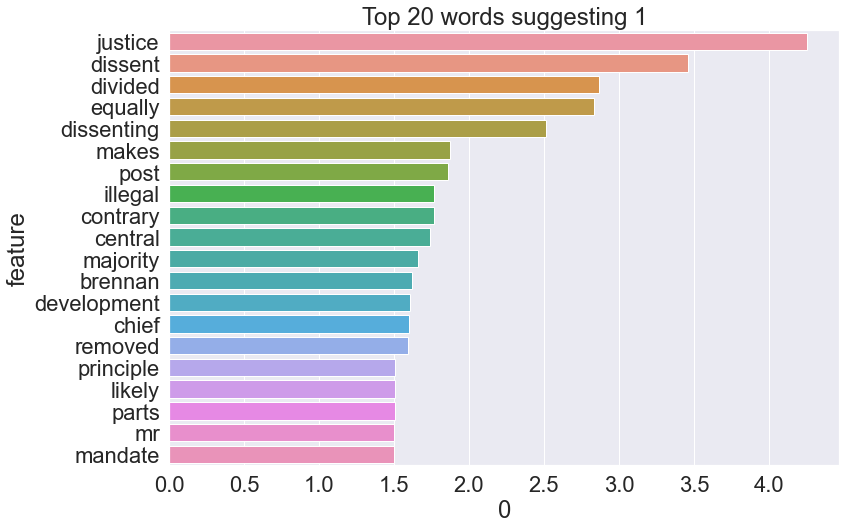

In [62]:
plot_top_coef(dict_df, num_to_plot = 20, x = 0, y = "feature")

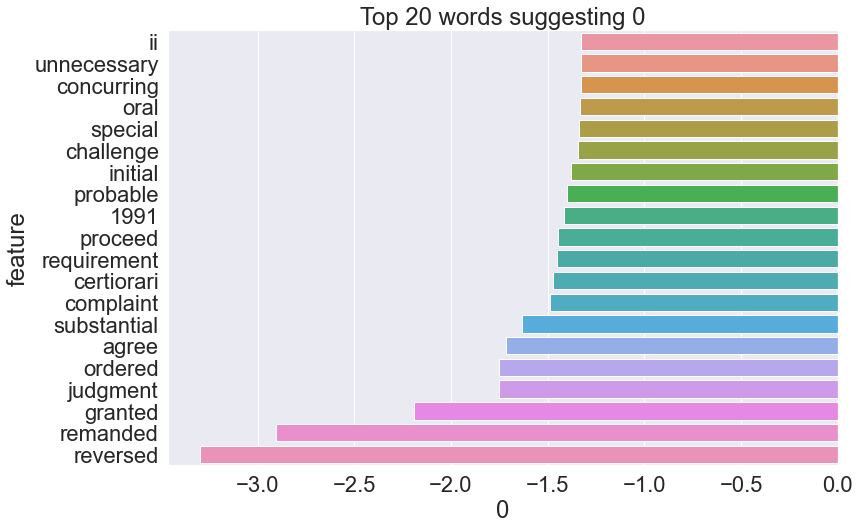

In [63]:
plot_top_coef(dict_df, more_like_1 = False, num_to_plot = 20, x = 0, y = "feature")

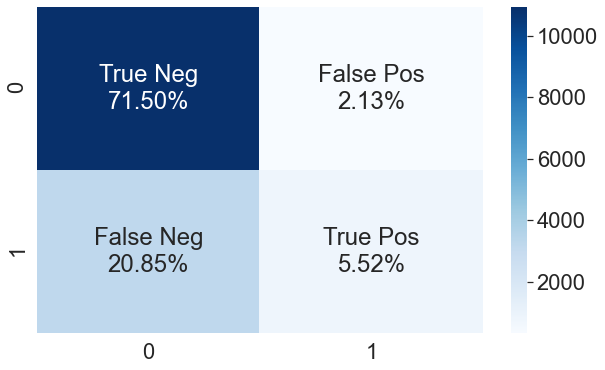

In [20]:
plot_confusion_matrix(X, y, lr)

## Precedent Alteration

In [ ]:
#X = vectorizer.fit_transform(metadata_df["text"])
#y = metadata_df["precedentAlteration"]

In [21]:
scores, test_f1, test_accuracy, lr, vectorizer, X, y = get_accuracy_scores(metadata_df, "text", "precedentAlteration")

In [22]:
print(test_f1)
print(test_accuracy)

0.005
0.9744394430979281


In [23]:
coef_dict, dict_df = get_coef_df(lr, vectorizer)

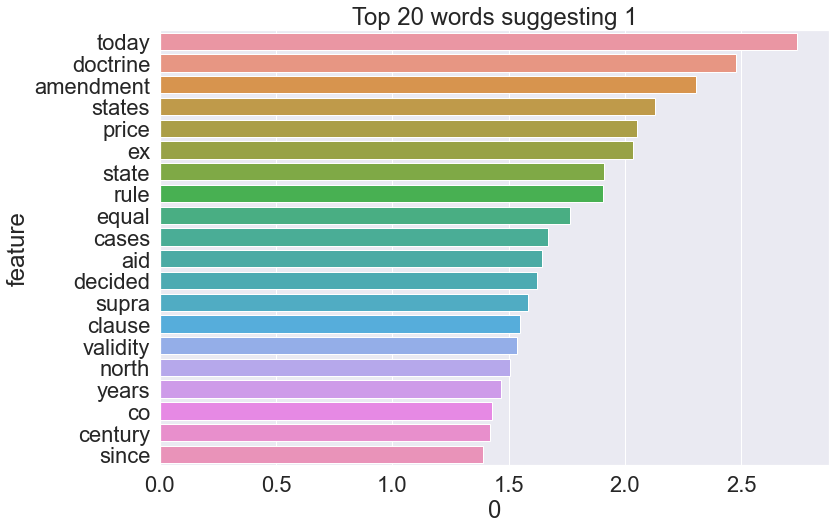

In [24]:
plot_top_coef(dict_df, num_to_plot = 20, x = 0, y = "feature")

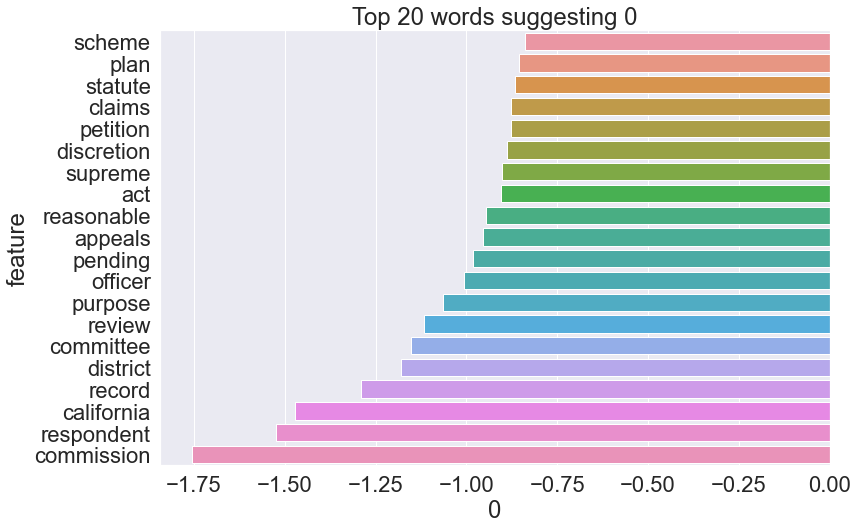

In [25]:
plot_top_coef(dict_df, more_like_1 = False, num_to_plot = 20, x = 0, y = "feature")

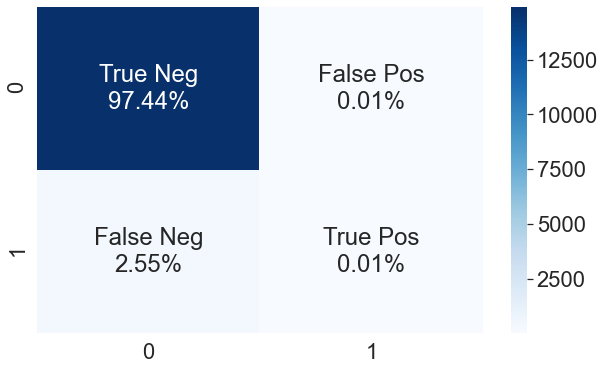

In [26]:
plot_confusion_matrix(X, y, lr)

## Unanimous and Per Curiam vs. Split Votes

In [ ]:
#X = vectorizer.fit_transform(unanimous_and_split_df["text"])
#y = unanimous_and_split_df["unan_v_split"].astype(int)

In [27]:
scores, test_f1, test_accuracy, lr, vectorizer, X, y = get_accuracy_scores(unanimous_and_split_df, "text", "unan_v_split")

In [28]:
print(test_f1)
print(test_accuracy)

0.7760290357729878
0.7425472755096465


In [29]:
coef_dict, dict_df = get_coef_df(lr, vectorizer)

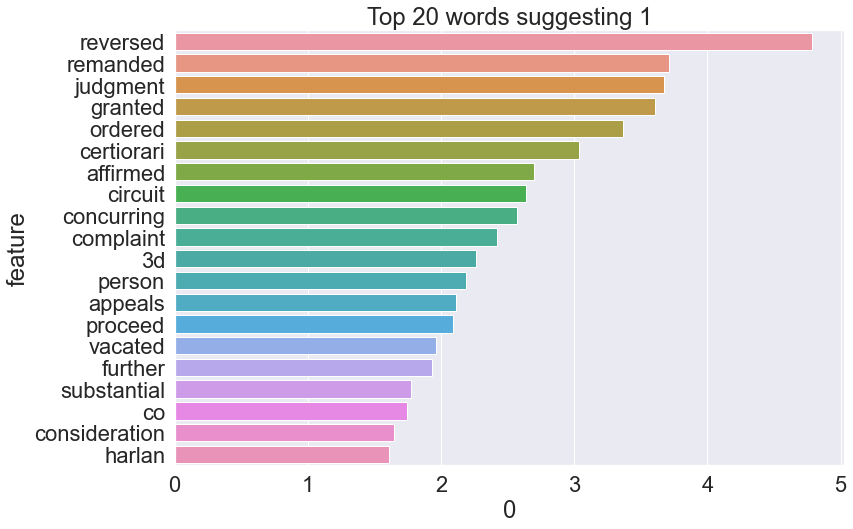

In [30]:
plot_top_coef(dict_df, num_to_plot = 20, x = 0, y = "feature")

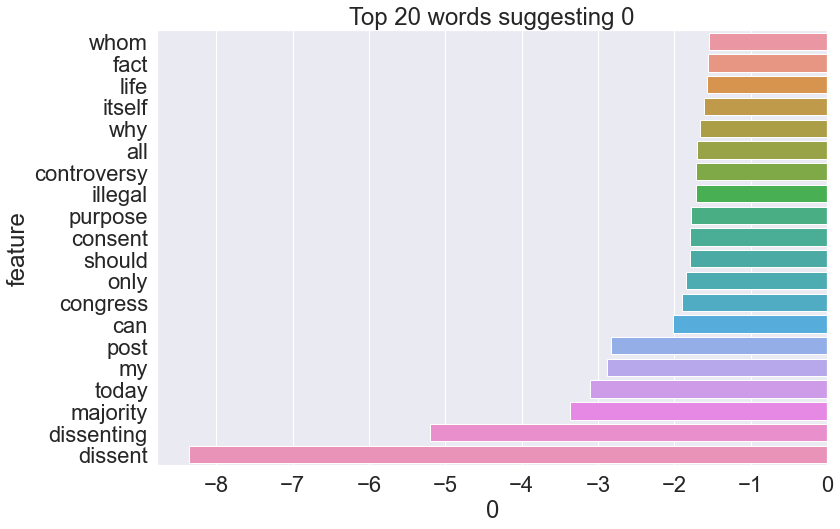

In [31]:
plot_top_coef(dict_df, more_like_1 = False, num_to_plot = 20, x = 0, y = "feature")

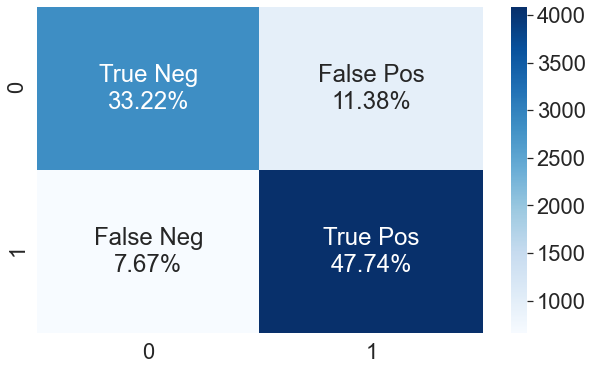

In [32]:
plot_confusion_matrix(X, y, lr)

## Unanimous vs. Per Curiam

In [ ]:
#X = vectorizer.fit_transform(unanimous_and_perc_df["text"])
#y = unanimous_and_perc_df["unan_v_percuriam"].astype(int)

In [33]:
scores, test_f1, test_accuracy, lr, vectorizer, X, y = get_accuracy_scores(unanimous_and_perc_df, "text", "unan_v_percuriam")

In [34]:
print(test_f1)
print(test_accuracy)

0.7903741823310036
0.9001757343823872


In [35]:
coef_dict, dict_df = get_coef_df(lr, vectorizer)

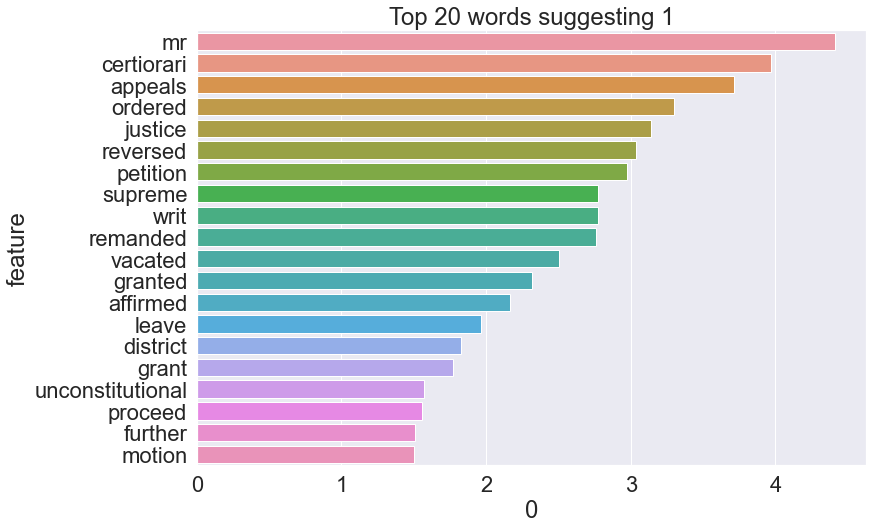

In [36]:
plot_top_coef(dict_df, num_to_plot = 20, x = 0, y = "feature")

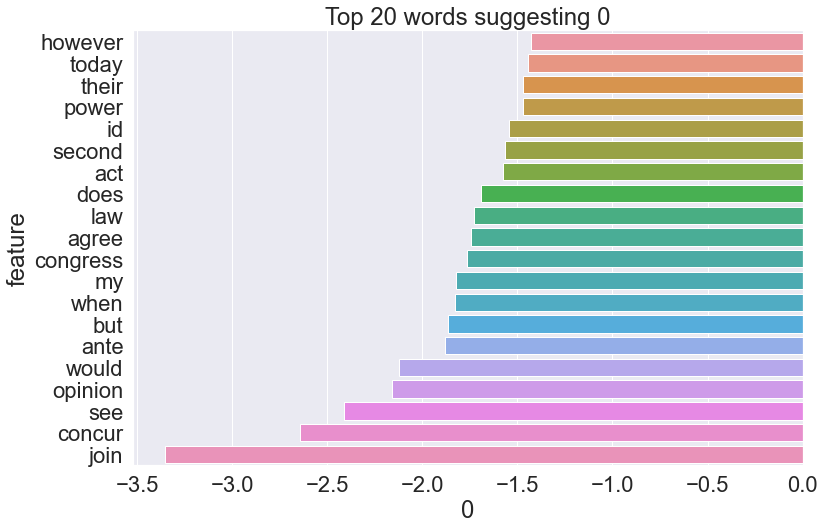

In [37]:
plot_top_coef(dict_df, more_like_1 = False, num_to_plot = 20, x = 0, y = "feature")

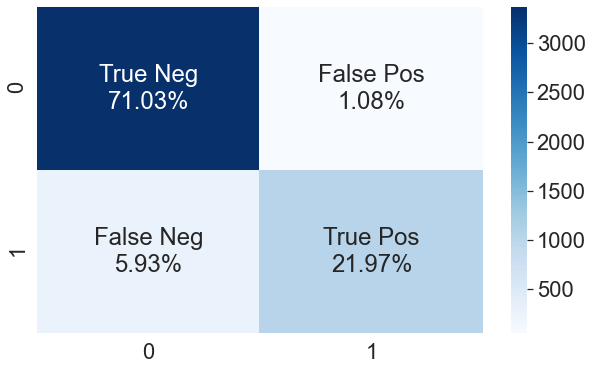

In [38]:
plot_confusion_matrix(X, y, lr)